# Problem Statement

1. We are given a dataset consisting of two csv files train_bodies.csv which contains the set of news articles bodies,while train-stances.csv resembles the articles for each of these bodies being identified using the body id.

2. After training from these samples we need to detect whether the given headline agrees,disagrees,discusses,unrelated with the body id


In [1]:
import os
import re
import pandas as pd
import numpy as np

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


In [2]:

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
!ls

# Loading the dataset

In [5]:
DATASET_PATH = "../input/fake-news-challenge/"

In [6]:
print(os.listdir(DATASET_PATH))

['train_stances.csv', 'test_stances_unlabeled.csv', 'train_bodies.csv', 'competition_test_bodies.csv', 'competition_test_stances_unlabeled.csv', 'test_bodies.csv']


**train_bodies.csv** contains body id and article body for training  
**train_stances.csv** contains headlines corresponding to body id and associated labelled stance with it


In [7]:
train_bodies = pd.read_csv(os.path.join(DATASET_PATH,'train_bodies.csv'))
train_bodies.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [8]:
print('The number of rows ',train_bodies.shape[0])
print('The number of columns',train_bodies.shape[1])

The number of rows  1683
The number of columns 2


In [9]:
train_bodies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Body ID      1683 non-null   int64 
 1   articleBody  1683 non-null   object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB


In [10]:
train_stance = pd.read_csv(os.path.join(DATASET_PATH,'train_stances.csv'))
train_stance.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [11]:
print('The number of rows ',train_stance.shape[0])
print('The number of columns',train_stance.shape[1])

The number of rows  49972
The number of columns 3


In [12]:
train_stance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  49972 non-null  object
 1   Body ID   49972 non-null  int64 
 2   Stance    49972 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [13]:
# the output signifies that each body id is associated to multiple headlines
train_stance['Body ID'].value_counts()

1921    187
1948    175
40      172
524     171
1549    166
       ... 
376       1
65        1
907       1
136       1
200       1
Name: Body ID, Length: 1683, dtype: int64

## Dataset understanding 

1. The train_bodies contain the entries for the body id and associated article Body
2. The train_stances contain the entries for the headlines associated with the particular body id and its labelled stance
3. One body present in train_bodies can have multiple associated headlines present in train_stances and it's corresponding stance label
4. 1683 :- Number of article Body present
5. 49972 number of total headlines present for the 1683 different article body

# Combining the CSV

I am preparing a final csv in each row will correspond to a unique entry
i.e each row will correspond to a unique combination of headline,bodyid and article body 

The above is needed for making simplicity in further data preparation steps we need to execute


In [14]:
# # #Run commented code to combine the two csv file{train_bodies.csv,train_stances.csv} into data_combined.csv file
from tqdm.notebook import tqdm
# # count=0
# # for i in tqdm(range(train_stance.shape[0])):
# #     for j in range(train_bodies.shape[0]):
# #         if train_bodies.loc[j,'Body ID']==train_stance.loc[i,'Body ID']:
# #             train_stance.loc[i,'articleBody'] = train_bodies.loc[j,'articleBody']
# # #     if i%100==0:
# # #         count+=1
# # #         print(count,end=' ')

# # train_stance.to_csv('data_combined.csv',index=False)

In [15]:
merged_df = pd.merge(train_stance, train_bodies,how='left', on='Body ID')
merged_df.to_csv('data_combined.csv', index=False)


In [16]:
data = pd.read_csv('data_combined.csv')
data.head()

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [17]:
data['stance_cat'] = data['Stance'].map({'agree':0,'disagree':1,'discuss':2,'unrelated':3}).astype(int)
data['Stance'].value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

## Data Preprocessing

In [18]:
stopwords_english = set(stopwords.words('english'))
data['Headline'] = data.Headline.apply(lambda x:str(x))
data.loc[:,'Headline'] = data['Headline'].apply(lambda x : str.lower(x))
data.loc[:,'Headline'] = data['Headline'].apply(lambda x:' '.join(re.findall('[\w]+',x)))
data.loc[:,'articleBody'] = data['articleBody'].apply(lambda x : str.lower(x))
data.loc[:,'articleBody'] = data['articleBody'].apply(lambda x:' '.join(re.findall('[\w]+',x)))


def remove_stopwords(s):
    return ' '.join(word for word in s.split() if word not in stopwords_english)

data['Headline'] = data['Headline'].apply(lambda x:remove_stopwords(x))
data['articleBody'] = data['articleBody'].apply(lambda x:str(x))
data['articleBody'] = data['articleBody'].apply(lambda x:remove_stopwords(x))

## Baseline Model For Two Class

### Creating the two class dataset of related/unrelated


For a baseline classification we are simplifying the classification problem to a two class classification by first taking only strong divergent classes related/unrelated 

In [19]:
data['stance_base'] = data.loc[data.loc[:,'Stance']=='unrelated','Stance']
data['stance_base'] = data['stance_base'].fillna("related")
print(data['stance_base'].value_counts())

unrelated    36545
related      13427
Name: stance_base, dtype: int64


In [20]:
data.head()

,Headline,Body ID,Stance,articleBody,stance_cat,stance_base
0,police find mass graves least 15 bodies near m...,712,unrelated,danny boyle directing untitled film seth rogen...,3,unrelated
1,hundreds palestinians flee floods gaza israel ...,158,agree,hundreds palestinians evacuated homes sunday m...,0,related
2,christian bale passes role steve jobs actor re...,137,unrelated,30 year old moscow resident hospitalized wound...,3,unrelated
3,hbo apple talks 15 month apple tv streaming se...,1034,unrelated,reuters canadian soldier shot canadian war mem...,3,unrelated
4,spider burrowed tourist stomach chest,1923,disagree,fear arachnophobes story bunbury spiderman mig...,1,related


In [21]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [22]:
def add_jaccard_similarity(data):
    count=0
    for i in tqdm(range(data.shape[0])):
        jaccard_lis=[];eps=0.001
        sentence = data.loc[i,'articleBody'].split('.') #per sentence scorer
        for j in range(len(sentence)):
            jaccard_lis.append(jaccard_similarity(data.loc[i,'Headline'].split(' '),sentence[j].split(' ')))
        max_jaccard_similarity = max(jaccard_lis)
        avg_jaccard_similarity = sum(jaccard_lis)/len(jaccard_lis)
        min_jaccard_similarity = min(jaccard_lis)
        data.loc[i,'jaccard_similarity'] = (max_jaccard_similarity+min_jaccard_similarity)/(max_jaccard_similarity-min_jaccard_similarity+eps)
#         if i%1000==0:
#             count+=1
#             print("Processed {0} Headlines".format(count*1000))
add_jaccard_similarity(data)    

  0%|          | 0/49972 [00:00<?, ?it/s]

## Classifying Two Classes Related/Unrelated



In [23]:
data['Stance'].value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

## Preparing Data for Classification

In [24]:
x = data.iloc[:,-1]
y = data['Stance']


xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.1)

rg = RandomForestClassifier(n_estimators=100,n_jobs=-1)

In [25]:
print('X Training shape',xtrain.shape)
print('Y Training shape',ytrain.shape)
xtrain = xtrain.values.reshape(-1,1)
xtest = xtest.values.reshape(-1,1)

X Training shape (44974,)
Y Training shape (44974,)


In [26]:
rg.fit(xtrain,ytrain)
ypred = rg.predict(xtest)

print('Accuracy score on two class agree and disagree ',accuracy_score(ypred,ytest))



Accuracy score on two class agree and disagree  0.8621448579431773


In [27]:
accuracy = accuracy_score(ypred,ytest)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ypred,ytest,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ypred,ytest,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ypred,ytest,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.862145
Precision: 0.901874
Recall: 0.862145
F1 score: 0.878446


## Four Class Classification

We are now doing the four class classification into categories 

1. unrelated  
2. discuss  
3. agree  
4. disagree  


In [28]:
data['Stance'].value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

In [29]:
x = data.iloc[:,-1]
y = data['Stance']

xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.1)

rg = RandomForestClassifier(n_estimators=100,n_jobs=-1)

In [30]:
np.shape(xtrain)

(44974,)

In [31]:
print('X Training shape',xtrain.shape)
print('Y Training shape',ytrain.shape)
xtrain = xtrain.values.reshape(-1,1)
xtest = xtest.values.reshape(-1,1)

X Training shape (44974,)
Y Training shape (44974,)


In [32]:
rg.fit(xtrain,ytrain)
ypred = rg.predict(xtest)


# print('Accuracy score on Four class {agree,disagree,discuss,unrelated}',accuracy_score(ypred,ytest))

In [33]:
print(ypred)

['discuss' 'unrelated' 'discuss' ... 'unrelated' 'unrelated' 'discuss']


In [34]:
class_names = ['agree', 'disagree','discuss', 'unrelated']
# labels = ['unrelated', 'discuss', 'discuss', ..., 'unrelated', 'discuss', 'unrelated']

# Convert labels to numerical indices
predyy = [class_names.index(label) for label in ypred]
testyy = [class_names.index(label) for label in ytest]
# print(numeric_labels)


In [35]:
accuracy = accuracy_score(ypred,ytest)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ypred,ytest,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ypred,ytest,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ypred,ytest,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.845538
Precision: 0.897639
Recall: 0.845538
F1 score: 0.867488


In [36]:
from sklearn.metrics import classification_report


In [37]:
rfcr = classification_report(ytest, ypred)

In [38]:
print(rfcr)

              precision    recall  f1-score   support

       agree       0.29      0.09      0.14       399
    disagree       0.07      0.01      0.02        90
     discuss       0.59      0.76      0.66       895
   unrelated       0.95      0.97      0.96      3614

    accuracy                           0.85      4998
   macro avg       0.47      0.46      0.44      4998
weighted avg       0.82      0.85      0.82      4998



**Please upvote the notebook if you found it usefull**  
Thanks 

In [39]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have your test data and labels
# test_data: Test data features
# test_labels: True labels for the test data

# Assuming you have your trained GloVe model loaded and ready for inference
# glove_model: Your trained GloVe model

# Step 1: Preprocess test data if necessary

# Step 2: Use the trained model to make predictions on the test data
# predicted_probabilities = model.predict([padded_docs_headline_test, padded_docs_bodytest])
# predicted_labels = np.argmax(predicted_probabilities, axis=1)
# print(predicted_labels)
# print(type(predicted_labels))
# print()
# print(labels_test)
# print(type(labels_test))
# Step 3: Convert predicted labels to class indices if necessary
# labels_test = np.argmax(labels_test, axis=1)

# Step 4: Generate confusion matrix
conf_matrix = confusion_matrix(testyy, predyy)

# Step 5: Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[  36    2  311   50]
 [   7    1   66   16]
 [  76   10  682  127]
 [   4    1  102 3507]]


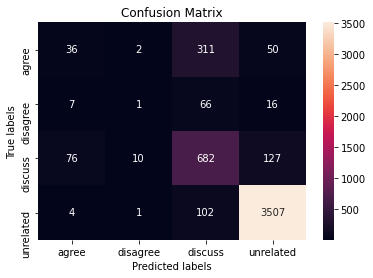

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);

In [41]:
## Logistic Regression

## Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(xtrain,ytrain)

LogisticRegression()

In [43]:
pred_lr=LR.predict(xtest)
LR.score(xtest, ytest)

0.8419367747098839

In [44]:

lrcr = classification_report(ytest, pred_lr)
print(lrcr)

              precision    recall  f1-score   support

       agree       1.00      0.01      0.01       399
    disagree       0.00      0.00      0.00        90
     discuss       0.59      0.75      0.66       895
   unrelated       0.91      0.98      0.95      3614

    accuracy                           0.84      4998
   macro avg       0.63      0.43      0.41      4998
weighted avg       0.85      0.84      0.80      4998



In [45]:
conf_matrix_lr = confusion_matrix(ytest, pred_lr)

# Step 5: Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix_lr)


Confusion Matrix:
[[   3    0  316   80]
 [   0    0   64   26]
 [   0    0  670  225]
 [   0    0   79 3535]]


In [54]:
class_report(LR)

              precision    recall  f1-score   support

       agree       1.00      0.01      0.01       399
    disagree       0.00      0.00      0.00        90
     discuss       0.59      0.75      0.66       895
   unrelated       0.91      0.98      0.95      3614

    accuracy                           0.84      4998
   macro avg       0.63      0.43      0.41      4998
weighted avg       0.85      0.84      0.80      4998



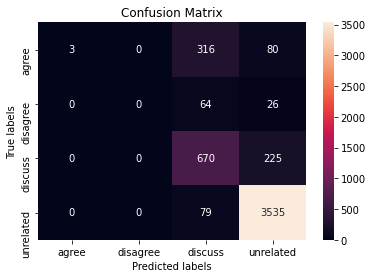

In [47]:
ax= plt.subplot()
sns.heatmap(conf_matrix_lr, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);

In [48]:
from pprint import pprint

In [50]:
def kfolds(model, model_name):
    model = cross_val_score(model, x,y, cv=10)
    model_score = np.average(model)
    print(f"{model_name} score on cross validation: {model_score * 100}%")

def train(model, model_name):
    model.fit(xtrain, ytrain)
    model_train_score = model.score(xtrain, ytrain)
    model_test_score = model.score(xtest, ytest)
    print(f"{model_name} model score on Training data: {model_train_score * 100}%\n{model_name} model score on Testing data: {model_test_score * 100}%")

def conf_matrix(model):
    ypred = model.predict(xtest)
    cm = confusion_matrix(ytest, ypred)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True, fmt='.2f');
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);
    
def class_report(model):
    ypred = model.predict(xtest)
    print(classification_report(ytest, ypred))
    
def roc(model, model_name):
    ypred_svm = model.decision_function(xtest)
    svm_fpr, svm_tpr, _ = roc_curve(ytest, ypred_svm)
    auc_svm = auc(svm_fpr, svm_tpr)
    plt.figure(figsize=(5, 5), dpi=100)
    plt.plot(svm_fpr, svm_tpr, color="darkorange", label=f'{model_name} (auc = %0.3f)' % auc_svm)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel('False Positive Rate -->')
    plt.ylabel('True Positive Rate -->')
    plt.legend()
    plt.show()

## KNN

In [51]:
knn = KNeighborsClassifier()
train(knn, "KNN")

KNN model score on Training data: 85.48494685818473%
KNN model score on Testing data: 82.71308523409364%


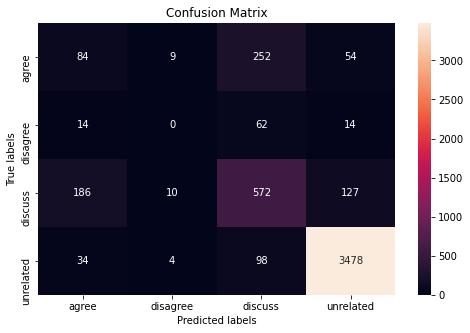

In [52]:
conf_matrix(knn)


In [53]:
class_report(knn)


              precision    recall  f1-score   support

       agree       0.26      0.21      0.23       399
    disagree       0.00      0.00      0.00        90
     discuss       0.58      0.64      0.61       895
   unrelated       0.95      0.96      0.95      3614

    accuracy                           0.83      4998
   macro avg       0.45      0.45      0.45      4998
weighted avg       0.81      0.83      0.82      4998



## Decision Tree

In [55]:
dt_model = DecisionTreeClassifier()
# kfolds(dt_model, "Decision_Tree")
train(dt_model, "Decision_Tree")

Decision_Tree model score on Training data: 87.63285453817761%
Decision_Tree model score on Testing data: 84.05362144857943%


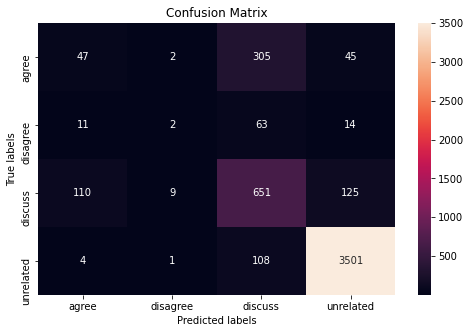

In [56]:
conf_matrix(dt_model)


In [57]:
class_report(dt_model)


              precision    recall  f1-score   support

       agree       0.27      0.12      0.16       399
    disagree       0.14      0.02      0.04        90
     discuss       0.58      0.73      0.64       895
   unrelated       0.95      0.97      0.96      3614

    accuracy                           0.84      4998
   macro avg       0.49      0.46      0.45      4998
weighted avg       0.81      0.84      0.82      4998



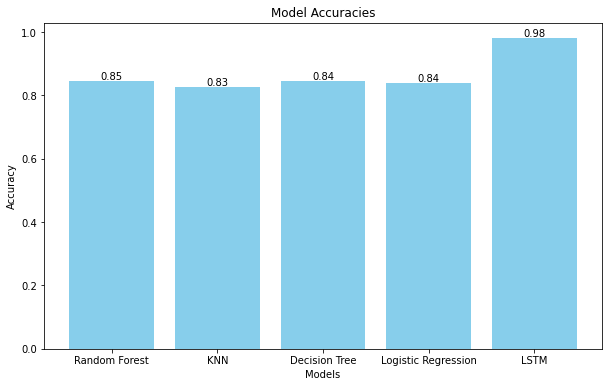

In [1]:
#changew values accordingly for graph comparison
import matplotlib.pyplot as plt

# Sample data: list of model names and their corresponding accuracies
model_names = ['Random Forest', 'KNN', 'Decision Tree', 'Logistic Regression', 'LSTM']
accuracies = [0.8455, 0.828, 0.845, 0.84, 0.9808]

# Create a bar graph
plt.figure(figsize=(10, 6))  # Optional: set the size of the figure
plt.bar(model_names, accuracies, color='skyblue')

# Add titles and labels
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Optional: add value labels on top of the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.005, f"{accuracy:.2f}", ha='center')

# Show the plot
plt.show()
